In [3]:
%matplotlib inline

from __future__ import print_function

import pandas
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as smtsa

import matplotlib.pyplot as pyplot

import thinkplot
import thinkstats2
import regression

FORMATS = ['png']


In [4]:
transactions = pandas.read_csv('mj-clean.csv', parse_dates=[5])

In [5]:
transactions.columns

Index([u'city', u'state', u'price', u'amount', u'quality', u'date', u'ppg',
       u'state.name', u'lat', u'lon'],
      dtype='object')

In [6]:
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [7]:
transactions.shape

(147070, 10)

In [8]:
def GroupByQualityAndDay(transactions):
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)
        
    return dailies

def GroupByDay(transactions, func=np.mean):
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)
    
    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year
    
    return daily

In [9]:
dailies = GroupByQualityAndDay(transactions)
dailies

{'high':                   ppg       date     years
 date                                      
 2010-09-02  13.384186 2010-09-02  0.000000
 2010-09-03  14.459588 2010-09-03  0.002738
 2010-09-04  14.923333 2010-09-04  0.005476
 2010-09-05  16.667500 2010-09-05  0.008214
 2010-09-06  15.537500 2010-09-06  0.010952
 2010-09-07  12.715000 2010-09-07  0.013690
 2010-09-08  13.865000 2010-09-08  0.016427
 2010-09-11  15.540000 2010-09-11  0.024641
 2010-09-12  11.310000 2010-09-12  0.027379
 2010-09-13  13.300000 2010-09-13  0.030117
 2010-09-14  13.670207 2010-09-14  0.032855
 2010-09-15  13.510101 2010-09-15  0.035593
 2010-09-16  13.483694 2010-09-16  0.038331
 2010-09-17  13.234431 2010-09-17  0.041069
 2010-09-18  13.656053 2010-09-18  0.043807
 2010-09-19  13.915778 2010-09-19  0.046544
 2010-09-20  13.769322 2010-09-20  0.049282
 2010-09-21  13.578381 2010-09-21  0.052020
 2010-09-22  13.563624 2010-09-22  0.054758
 2010-09-23  13.644103 2010-09-23  0.057496
 2010-09-24  13.050305 2

/Users/nathankiner/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/nathankiner/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


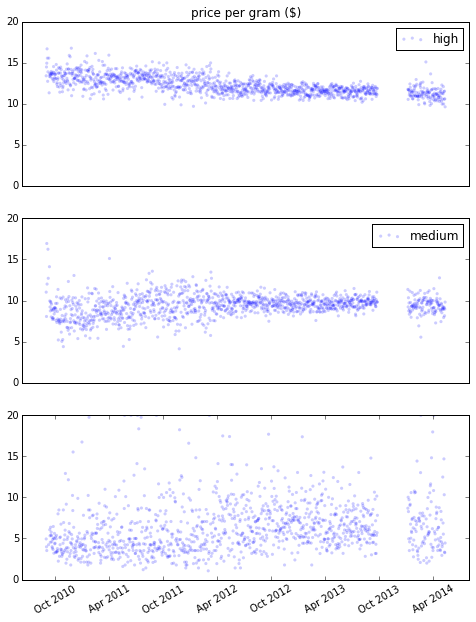

In [8]:
thinkplot.PrePlot(rows=3)
for i, (name, daily) in enumerate(dailies.items()):
    thinkplot.SubPlot(i+1)
    title = 'price per gram ($)' if i == 0 else ''
    thinkplot.Config(ylim=[0,20], title=title)
    thinkplot.Scatter(daily.index, daily.ppg, s=10, label=name)
    if i == 2:
        pyplot.xticks(rotation=30)
    else:
        thinkplot.Config(xticks=[])

In [9]:
def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

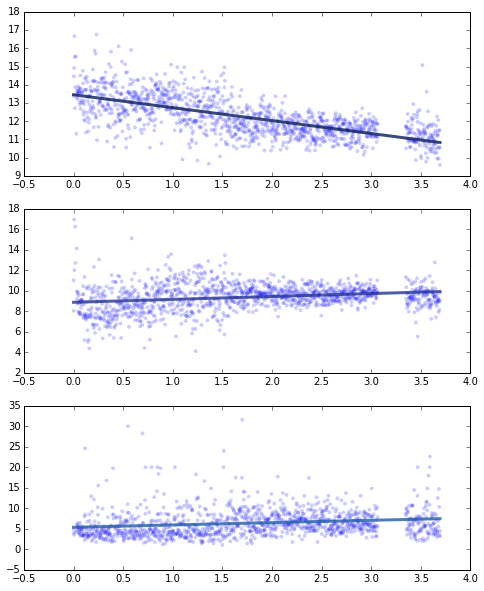

In [11]:
thinkplot.PrePlot(rows=3)
i = 1
for name, daily in dailies.items():
    thinkplot.SubPlot(i)
    model, results = RunLinearModel(daily)
    PlotFittedValues(model, results, label=name)
    i += 1

In [10]:
def PlotFittedValues(model, results, label=''):
    years = model.exog[:,1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model')

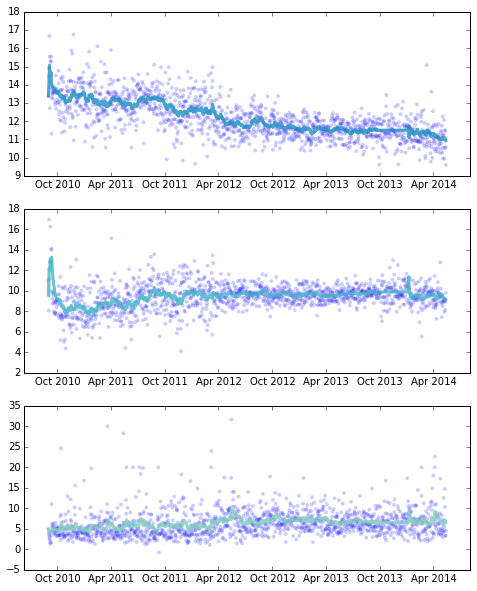

In [12]:
thinkplot.PrePlot(rows=3)
i = 1
for name, daily in dailies.items():
    thinkplot.SubPlot(i)
    dates = pandas.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)
    ewma = pandas.ewma(reindexed.ppg, span=30)
    res = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(res, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)
    thinkplot.Scatter(reindexed.index, reindexed.ppg, s=15, label=name)
    thinkplot.Plot(ewma.index, ewma)
    i += 1

In [13]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

NameError: name 'SimulateAutocorrelation' is not defined

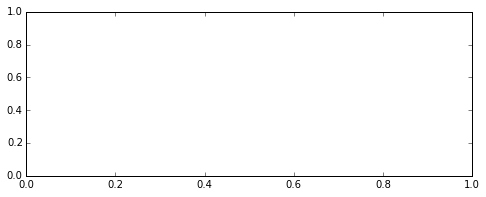

In [14]:
lag_corr = {}
nlags = 365
thinkplot.PrePlot(rows = 3)
i = 1
for name, daily in dailies.items():
    dates = pandas.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)
    
    ewma = pandas.ewma(reindexed.ppg, span=30)
    res = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(res, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)
    
    rolling_mean = pandas.rolling_mean(reindexed.ppg, 30)
    ewma = pandas.ewma(reindexed.ppg, span=30)
    res = (reindexed.ppg - ewma).dropna()
    
    lag_corr[name] = []
    acf = smtsa.acf(res, nlags=nlags, unbiased=True)
    thinkplot.SubPlot(i)
    SimulateAutocorrelation(daily, nlags=nlags)
    thinkplot.Plot(acf, label=name)
    i += 1
    thinkplot.Show(axis=[0,nlags,-.1,.1])

In [15]:
def SimulateAutocorrelation(daily, iters=1001, nlags=40):
    """Resample residuals, compute autocorrelation, and plot percentiles.

    daily: DataFrame
    iters: number of simulations to run
    nlags: maximum lags to compute autocorrelation
    """
    # run simulations
    t = []
    for _ in range(iters):
        filled = FillMissing(daily, span=30)
        resid = thinkstats2.Resample(filled.resid)
        acf = smtsa.acf(resid, nlags=nlags, unbiased=True)[1:]
        t.append(np.abs(acf))

    high = thinkstats2.PercentileRows(t, [97.5])[0]
    low = -high
    lags = range(1, nlags+1)
    thinkplot.FillBetween(lags, low, high, alpha=0.2, color='gray')

In [16]:
def FillMissing(daily, span=30):
    """Fills missing values with an exponentially weighted moving average.

    Resulting DataFrame has new columns 'ewma' and 'resid'.

    daily: DataFrame of daily prices
    span: window size (sort of) passed to ewma

    returns: new DataFrame of daily prices
    """
    dates = pandas.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    ewma = pandas.ewma(reindexed.ppg, span=span)

    resid = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(resid, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)

    reindexed['ewma'] = ewma
    reindexed['resid'] = reindexed.ppg - ewma
    return reindexed

In [17]:
def AddWeeklySeasonality(daily, inc=2):
    frisat = (daily.index.dayofweek == 4) | (daily.index.dayofweek == 5)
    fake = daily.copy()
    fake.ppg[frisat] += np.random.uniform(0, inc, frisat.sum())
    return fake

/Users/nathankiner/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


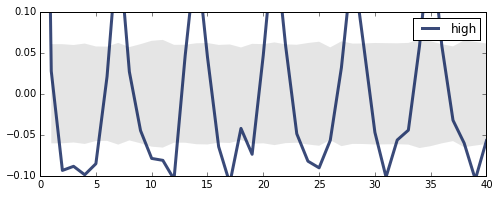

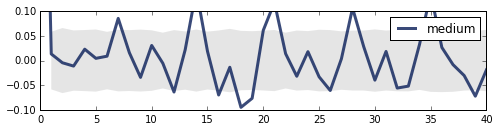

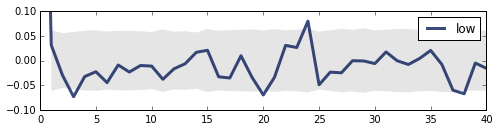

In [83]:
lag_corr = {}
nlags = 40
thinkplot.PrePlot(rows = 3)
i = 1
for name, daily in dailies.items():
    fdaily = AddWeeklySeasonality(daily, 2)
    dates = pandas.date_range(fdaily.index.min(), fdaily.index.max())
    reindexed = fdaily.reindex(dates)
    
    ewma = pandas.ewma(reindexed.ppg, span=30)
    res = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(res, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)
    
    rolling_mean = pandas.rolling_mean(reindexed.ppg, 30)
    ewma = pandas.ewma(reindexed.ppg, span=30)
    res = (reindexed.ppg - ewma).dropna()
    
    lag_corr[name] = []
    acf = smtsa.acf(res, nlags=nlags, unbiased=True)
    thinkplot.SubPlot(i)
    SimulateAutocorrelation(fdaily, nlags=nlags)
    thinkplot.Plot(acf, label=name)
    i += 1
    thinkplot.Show(axis=[0,nlags,-.1,.1])

In [18]:
def GenerateSimplePrediction(results, years):
    """Generates a simple prediction.

    results: results object
    years: sequence of times (in years) to make predictions for

    returns: sequence of predicted values
    """
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years)
    predict_df = pandas.DataFrame(d)
    predict = results.predict(predict_df)
    return predict

In [19]:
def RunQuadraticModel(daily):
    daily["years2"] = daily.years**2
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results

                            OLS Regression Results                            
Dep. Variable:                    ppg   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     349.6
Date:                Mon, 23 Nov 2015   Prob (F-statistic):          2.16e-164
Time:                        13:13:10   Log-Likelihood:                -1493.4
No. Observations:                1241   AIC:                             2995.
Df Residuals:                    1237   BIC:                             3015.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     13.5302      0.089    152.075      0.0

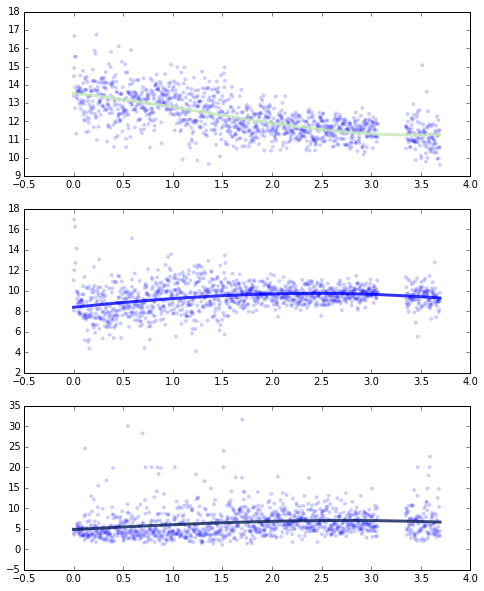

In [38]:
thinkplot.PrePlot(rows=3)
i = 1
for name, daily in dailies.items():
    thinkplot.SubPlot(i)
    model, results = RunPolyModel(daily,2)
    print(results.summary())
    PlotFittedValues(model, results, label=name)
    i += 1

In [29]:
def RunPolyModel(daily, pow=1):
    formula = 'ppg ~ years'
    if pow > 1:
        for i in xrange(2,pow + 1):
            name = "years" + str(i)
            daily[name] = daily.years**i
            formula += ' + ' + name
    model = smf.ols(formula, data=daily)
    results = model.fit()
    return model, results

In [39]:
def GenerateSimplePrediction(results, years):
    """Generates a simple prediction.

    results: results object
    years: sequence of times (in years) to make predictions for

    returns: sequence of predicted values
    """
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years, years2=years**2)
    print(d)
    # predict_df = pandas.DataFrame(d)
    # predict = results.predict(predict_df)
    # print(predict)
    # return predict

In [41]:
GenerateSimplePrediction(results, [1])

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

In [58]:
def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    
    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pandas.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

In [48]:
def SimulateResults(daily, iters=101, func=RunLinearModel):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

In [49]:
def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

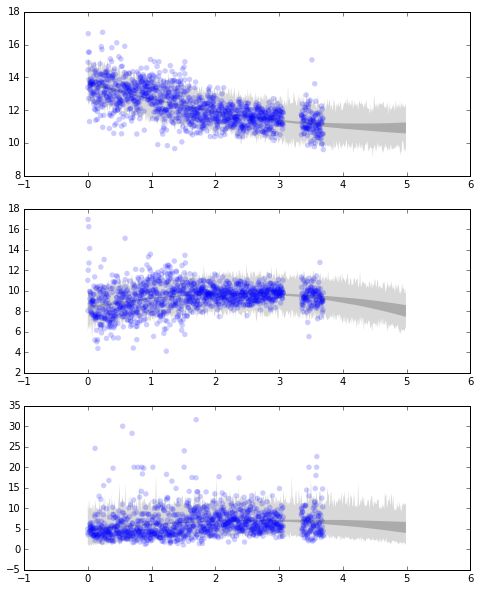

In [59]:
thinkplot.PrePlot(rows=3)
i = 1
for name, daily in dailies.items():
    thinkplot.SubPlot(i)
    start = daily.years.min()
    PlotPredictions(daily=daily, years=np.arange(start, 5, 0.01), func=RunQuadraticModel)
    thinkplot.Scatter(daily.years, daily.ppg)
    i += 1

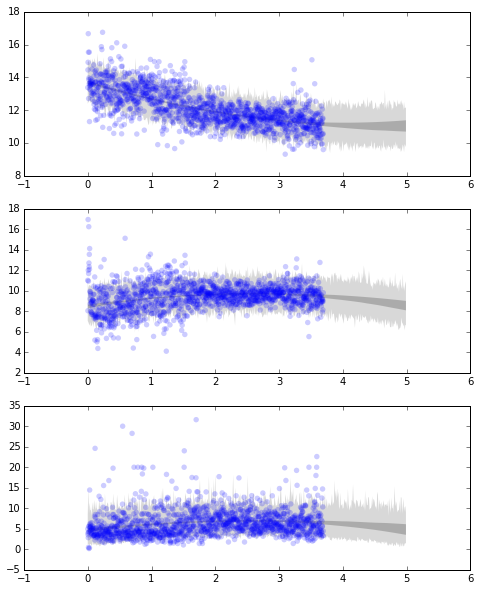

In [84]:
thinkplot.PrePlot(rows=3)
i = 1
for name, daily in dailies.items():
    thinkplot.SubPlot(i)
    
    dates = pandas.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)
    
    ewma = pandas.ewma(reindexed.ppg, span=30)
    res = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(res, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)
    reindexed.date = reindexed.index
    
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    reindexed.years = (reindexed.date - start) / one_year
    
    start = reindexed.years.min()
    PlotPredictions(daily=reindexed, years=np.arange(start, 5, 0.01), func=RunQuadraticModel)
    thinkplot.Scatter(reindexed.years, reindexed.ppg)
    i += 1

In [131]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    """Tests serial correlations by permutation."""

    def __init__(self, data, lag):
        self.data = ReindexData(data)
        self.lag = lag
        self.actual = self.TestStatistic(self.data)
    
    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        test_stat = abs(thinkstats2.SerialCorr(data.ppg, self.lag))
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        test_data = self.data.copy()
        test_ppg = thinkstats2.Resample(self.data.ppg)
        test_data.ppg = test_ppg
        return test_data

In [14]:
def ReindexData(daily):
    dates = pandas.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)
    
    ewma = pandas.ewma(reindexed.ppg, span=30)
    res = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(res, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)
    return reindexed

In [134]:
for name, daily in dailies.items():
    sct = SerialCorrelationTest(daily, 1)
    print(name, '{0:.5f}'.format(sct.PValue(iters=5000)))

high 0.00000
medium 0.00000
low 0.00000


In [135]:
class SerialCorrelationTest2(thinkstats2.HypothesisTest):
    """Tests serial correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        series, lag = data
        test_stat = abs(thinkstats2.SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [118]:
for name, daily in dailies.items():
    sct = SerialCorrelationTest2((daily.ppg, 1))
    print(name, '{0:.3f}'.format(sct.PValue(iters=5000)))

high 0.000
medium 0.000
low 0.000


In [12]:
def EWMAPredict(daily, date):
    results = ReindexData(daily.copy())
    
    date_ranges = pandas.date_range(results.index.max(), date)
    for day in date_ranges:
        ewma = pandas.ewma(results.ppg, span=30)
        inter = ewma[-1]
        ewma_slope = pandas.ewma(results.ppg.diff(), span=30).dropna()
        slope = ewma_slope[-1]
        
        results.reindex(pandas.date_range(results.index.min(), day))
        results.ppg[-1] = inter + slope
        
    results = results[daily.index.max():]
    return results

/Users/nathankiner/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nathankiner/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


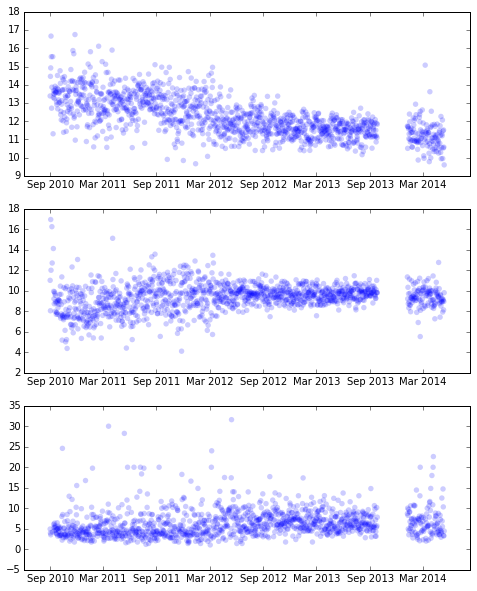

In [15]:
thinkplot.PrePlot(rows=3)
i = 1
for name, daily in dailies.items():
    thinkplot.SubPlot(i)
    results = EWMAPredict(daily, '2015-01-01')
    thinkplot.Scatter(daily.index, daily.ppg)
    thinkplot.Plot(results.index, results.ppg)
    i += 1

In [10]:
for name, daily in dailies.items():
    print(daily.index.max())

2014-05-13 00:00:00
2014-05-13 00:00:00
2014-05-13 00:00:00
